# Explanatory Data Analysis and Preprocessing

### Data Structure

In this case the data are structured as follows in order to recreate the project.
```
.
├── Healthcare 
│   └── data.csv
├── Heart_Rate_Prediction
│   ├── Test Data
│   │   ├── hr_non_linear.csv
│   │   └── hr_time_domain.csv
│   └── Train Data
│       ├── hr_non_linear.csv
│       └── hr_time_domain.csv
├── SWELL
│   ├── test.csv
│   └── train.csv
└── Stress_predict
    ├── Questionnaires_scores.xlsx
    ├── Time_logs.xlsx
    └── data.csv
```


In [1]:
# Import Libraries
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hrv_calculator import compute_hrv_from_heart_rate


# Import Data Paths
data_path = os.getcwd() + "/data" 

## Healthcare dataset for Nurse Stress Prediction with Wearable devices

- Data Collection Context:
    - Period: Data gathered over one week from 15 female nurses aged 30 to 55 years

- Data Captured:
    - Physiological Variables Monitored: Heart Rate of the nurse subjects.
    - Survey Responses: Periodic smartphone-administered surveys capturing contributing factors to detected stress events.
    - Measurement Technologies: Utilized Empatica E4 for data collection, specifically focusing on Blood Volume Pulse (BVP) readings.

- Merge CSV File Information:
    - This dataset comprises approximately 11.5 million entries across nine columns:
    - X, Y, Z: Orientation data (256 unique entries each).
    - EDA, HR, TEMP: Physiological measurements (EDA: 274,452 unique, HR: 6,268 unique, TEMP: 599 unique).
    - id: 18 categorical identifiers.
    - datetime: Extensive date and time entries (10.6 million unique).
    - label: Categorical states or classes (three unique entries).

In [2]:
# Data path 
health_care_path = os.path.join(data_path, "Healthcare/data.csv")
nurses_pd = pd.read_csv(health_care_path)
print("The initial data contains {} rows and {} columns.".format(nurses_pd.shape[0], nurses_pd.shape[1]))

# Data Preprocessing (drop unnecessary columns and convert label to int)
data_pd = nurses_pd.drop(columns=["X", "Y", "Z", "EDA", "TEMP", "id"])
print("The data we are interested in contains {} rows and {} columns.".format(data_pd.shape[0], data_pd.shape[1]))

# Calculate time difference between consecutive samples (in seconds), drop the first NaN and calculate average time
# Ensure the datetime column is of datetime type
data_pd["datetime"] = pd.to_datetime(data_pd["datetime"])
data_pd = data_pd.sort_values(by="datetime")
data_pd["time_diff"] = data_pd["datetime"].diff().dt.total_seconds()
data_pd = data_pd.dropna(subset=["time_diff"])
average_time_diff = data_pd["time_diff"].mean()
data_pd.drop(columns=["time_diff"], inplace=True)

# Calculate frequency (Hz)
sampling_frequency_hz = 1 / average_time_diff
print(f"Average Time Between Samples: {average_time_diff:.6f} seconds")
print(f"Sampling Frequency: {sampling_frequency_hz:.2f} Hz")

/var/folders/k5/22sywl_15k17yky84cqwzc_80000gn/T/ipykernel_61898/3214513553.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  nurses_pd = pd.read_csv(health_care_path)


The initial data contains 11509051 rows and 9 columns.
The data we are interested in contains 11509051 rows and 3 columns.
Average Time Between Samples: 1.819698 seconds
Sampling Frequency: 0.55 Hz


In [3]:
# Resample to 1-second intervals using average
data_pd.set_index('datetime', inplace=True)
resampled_df = data_pd.resample('1S').mean(numeric_only=True)
resampled_df = resampled_df.dropna(subset=['HR'])
resampled_df["label"] = resampled_df["label"].astype(int)
resampled_df.to_csv(os.path.join(data_path, "Healthcare/resampled_data.csv"), index=True)
print("The data after resampling contains {} rows and {} columns.".format(resampled_df.shape[0], resampled_df.shape[1]))

The data after resampling contains 332307 rows and 2 columns.


In [4]:
# Load the downsampled data
data_pd = pd.read_csv(os.path.join(data_path, "Healthcare/resampled_data.csv"))
heart_rates = data_pd["HR"].value_counts()
labels = data_pd["label"].value_counts()

# Simple Statistical Analysis
mean_heart_rate = data_pd["HR"].mean()
median_heart_rate = data_pd["HR"].median()
std_heart_rate = data_pd["HR"].std()

print("The mean heart rate is {:.2f} bpm.".format(mean_heart_rate))
print("The median heart rate is {:.2f} bpm.".format(median_heart_rate))
print("The standard deviation of heart rate is {:.2f} bpm.".format(std_heart_rate))

The mean heart rate is 85.75 bpm.
The median heart rate is 84.07 bpm.
The standard deviation of heart rate is 14.06 bpm.


[Text(2, 0, '2'), Text(0, 0, '0'), Text(1, 0, '1')]

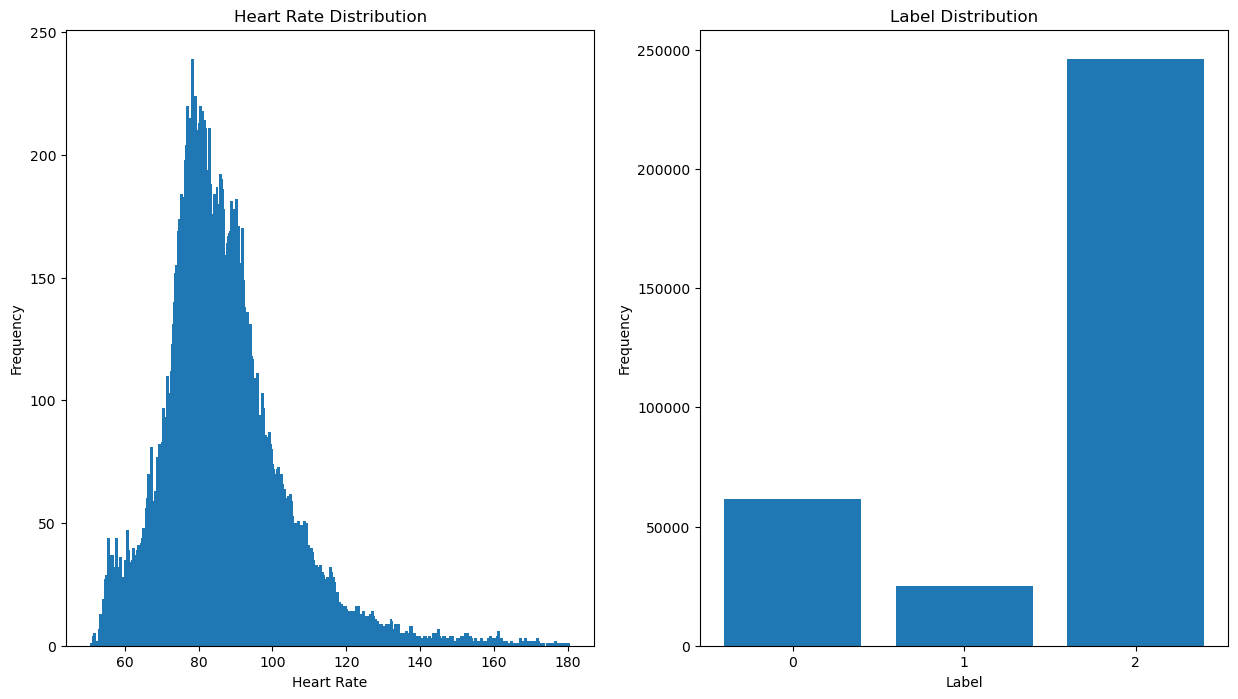

In [5]:
# Plot statistical data for the dataset
nrows = 1
ncols = 2

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 8))

axs[0].bar(heart_rates.index, heart_rates.values)
axs[0].set_title("Heart Rate Distribution")
axs[0].set_xlabel("Heart Rate")
axs[0].set_ylabel("Frequency")

axs[1].bar(labels.index, labels.values)
axs[1].set_title("Label Distribution")
axs[1].set_xlabel("Label")
axs[1].set_ylabel("Frequency")
axs[1].set_xticks(labels.index)
axs[1].set_xticklabels(labels.index.astype(int))

The data with HRV contains 332307 rows and 4 columns.


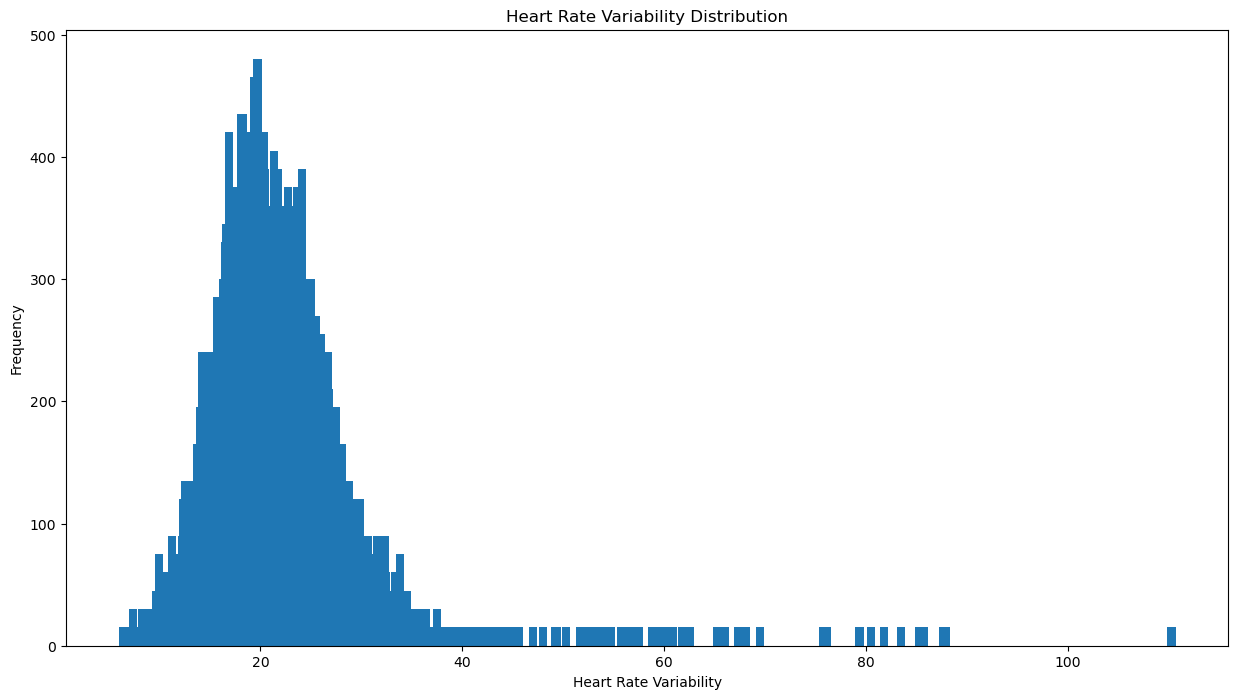

In [6]:
# Create a new column for HRV, calculate the difference between consecutive heart rates every 15 seconds
step = 15

# New HRV column to be filled
hrv_values = []

for i in range(0, len(data_pd), step):
    chunk = data_pd.iloc[i:i+step]
    if len(chunk) == step:
        hr_list = chunk["HR"].tolist()
        ts_list = chunk["datetime"].astype(str).tolist()
        hrv_result = compute_hrv_from_heart_rate(hr_list, windowed=False, timestamps=ts_list, use_jitter=True)
        hrv_rmssd = hrv_result["rmssd"]
        hrv_values.extend([hrv_rmssd] * 15)
    else:
        hrv_values.extend([np.nan] * len(chunk))

# Assign to new column
data_pd["HRV"] = hrv_values

# Export the data and delete downsampled data
data_pd = data_pd[["HR", "HRV", "datetime", "label"]]
data_pd.to_csv(os.path.join(data_path, "Healthcare/hrv.csv"), index=False)
print("The data with HRV contains {} rows and {} columns.".format(data_pd.shape[0], data_pd.shape[1]))

# Plot statistical data for the dataset
hrvs = data_pd["HRV"].value_counts()
nrows = 1
ncols = 1

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 8))

axs.bar(hrvs.index, hrvs.values)
axs.set_title("Heart Rate Variability Distribution")
axs.set_xlabel("Heart Rate Variability")
axs.set_ylabel("Frequency")

# Detete the resampled data
os.remove(os.path.join(data_path, "Healthcare/resampled_data.csv"))

---

## Heart Rate Prediction to Monitor Stress Level
The data comprises various attributes taken from signals measured using ECG recorded for different individuals having different heart rates at the time the measurement was taken. These various features contribute to the heart rate at the given instant of time for the individual.

There are total of 6 CSV files with the names as follows:
- Train:
    - time_domain_features_train.csv - This file contains all time domain features of heart rate for training data
    - frequency_domain_features_train.csv - This file contains all frequency domain features of heart rate for training data
    - heart_rate_non_linear_features_train.csv - This file contains all non linear features of heart rate for training data

- Test: 
    - time_domain_features_test.csv - This file contains all time domain features of heart rate for testing data
    - frequency_domain_features_test.csv - This file contains all frequency domain features of heart rate for testing data
    - heart_rate_non_linear_features_test.csv - This file contains all non linear features of heart rate for testing data

Following is the data dictionary for the features you will come across in the files mentioned:
- MEAN_RR - Mean of RR intervals
- MEDIAN_RR - Median of RR intervals
- SDRR - Standard deviation of RR intervals
- **RMSSD - Root mean square of successive RR interval differences**
- SDSD - Standard deviation of successive RR interval differences
- SDRR_RMSSD - Ratio of SDRR / RMSSD
- pNN25 - Percentage of successive RR intervals that differ by more than 25 ms
- pNN50 - Percentage of successive RR intervals that differ by more than 50 ms
- KURT - Kurtosis of distribution of successive RR intervals
- SKEW - Skew of distribution of successive RR intervals
- MEAN_REL_RR - Mean of relative RR intervals
- MEDIAN_REL_RR - Median of relative RR intervals
- SDRR_REL_RR - Standard deviation of relative RR intervals
- RMSSD_REL_RR - Root mean square of successive relative RR interval differences
- SDSD_REL_RR - Standard deviation of successive relative RR interval differences
- SDRR_RMSSD_REL_RR - Ratio of SDRR/RMSSD for relative RR interval differences
- KURT_REL_RR - Kurtosis of distribution of relative RR intervals
- SKEW_REL_RR - Skewness of distribution of relative RR intervals
- **uuid - Unique ID for each patient**
- VLF - Absolute power of the very low frequency band (0.0033 - 0.04 Hz)
- VLF_PCT - Principal component transform of VLF
- LF - Absolute power of the low frequency band (0.04 - 0.15 Hz)
- LF_PCT - Principal component transform of LF
- LF_NU - Absolute power of the low frequency band in normal units
- HF - Absolute power of the high frequency band (0.15 - 0.4 Hz)
- HF_PCT - Principal component transform of HF
- HF_NU - Absolute power of the highest frequency band in normal units
- TP - Total power of RR intervals
- LF_HF - Ratio of LF to HF
- HF_LF - Ratio of HF to LF
- SD1 - Poincaré plot standard deviation perpendicular to the line of identity
- SD2 - Poincaré plot standard deviation along the line of identity
- Sampen - sample entropy which measures the regularity and complexity of a time series
- higuci - higuci fractal dimension of heartrate
- datasetId - ID of the whole dataset
- **condition - condition of the patient at the time the data was recorded**
- **HR - Heart rate of the patient at the time of data recorded**

In [7]:
# Data path 
train_non_linear_path  = os.path.join(data_path,  "Heart_Rate_Prediction/Train_Data/hr_non_linear.csv")
train_time_domain_path = os.path.join(data_path, "Heart_Rate_Prediction/Train_Data/hr_time_domain.csv")

test_non_linear_path  = os.path.join(data_path,  "Heart_Rate_Prediction/Test_Data/hr_non_linear.csv")
test_time_domain_path = os.path.join(data_path, "Heart_Rate_Prediction/Test_Data/hr_time_domain.csv")

In [8]:
# Train data pipeline
train_non_linear_df  = pd.read_csv(train_non_linear_path)
train_time_domain_df = pd.read_csv(train_time_domain_path)
print("The initial non linear  train data contains {} rows and {} columns.".format(train_non_linear_df.shape[0], train_non_linear_df.shape[1]))
print("The initial time domain train data contains {} rows and {} columns.".format(train_time_domain_df.shape[0], train_time_domain_df.shape[1]))

# Drop unnecessary columns and join the data in one new dataframe
train_non_linear_df = train_non_linear_df.drop(columns=["SD1", "SD2", "sampen", "higuci", "datasetId"], axis=1)

columns_to_drop = ["MEAN_RR","MEDIAN_RR","SDRR","SDSD","SDRR_RMSSD","pNN25","pNN50","KURT","SKEW","MEAN_REL_RR","MEDIAN_REL_RR","SDRR_REL_RR",
                  "RMSSD_REL_RR","SDSD_REL_RR","SDRR_RMSSD_REL_RR","KURT_REL_RR","SKEW_REL_RR"]
train_time_domain_df = train_time_domain_df.drop(columns=columns_to_drop, axis=1)


# Merge the two dataframes
train_data = pd.merge(train_non_linear_df, train_time_domain_df, on=["uuid"], how="inner")
train_data["HR"] = data_pd["HR"].astype(int)
train_data.to_csv(os.path.join(data_path, "Heart_Rate_Prediction/Train_Data/train.csv"), index=False)
print("The merged train data contains {} rows and {} columns.".format(train_data.shape[0], train_data.shape[1]))

The initial non linear  train data contains 369289 rows and 7 columns.
The initial time domain train data contains 369289 rows and 20 columns.
The merged train data contains 369289 rows and 4 columns.


The mean heart rate is 85.26 bpm.
The median heart rate is 84.00 bpm.
The standard deviation of heart rate is 14.07 bpm.


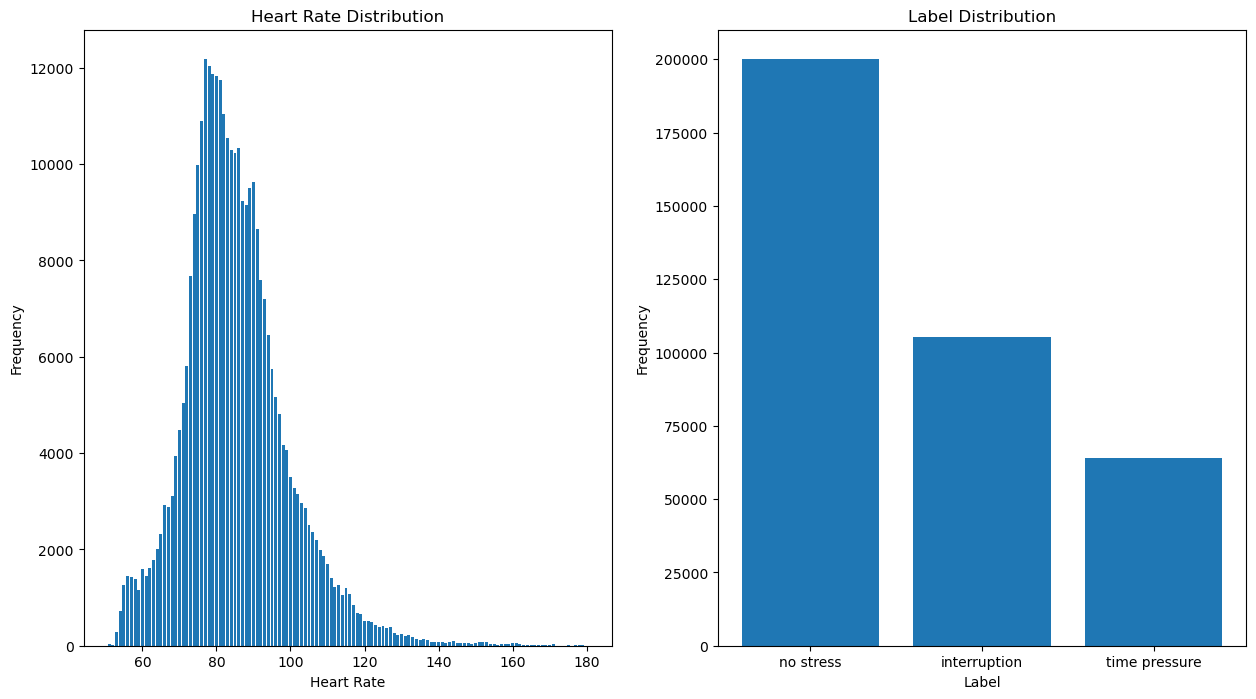

In [9]:
heart_rates = train_data["HR"].value_counts()
labels = train_data["condition"].value_counts()

# Simple Statistical Analysis
mean_heart_rate = train_data["HR"].mean()
median_heart_rate = train_data["HR"].median()
std_heart_rate = train_data["HR"].std()

print("The mean heart rate is {:.2f} bpm.".format(mean_heart_rate))
print("The median heart rate is {:.2f} bpm.".format(median_heart_rate))
print("The standard deviation of heart rate is {:.2f} bpm.".format(std_heart_rate))

# Plot statistical data for the dataset
nrows = 1
ncols = 2

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 8))

axs[0].bar(heart_rates.index, heart_rates.values)
axs[0].set_title("Heart Rate Distribution")
axs[0].set_xlabel("Heart Rate")
axs[0].set_ylabel("Frequency")

axs[1].bar(labels.index, labels.values)
axs[1].set_title("Label Distribution")
axs[1].set_xlabel("Label")
axs[1].set_ylabel("Frequency")
axs[1].set_xticks(labels.index)

Text(0, 0.5, 'Frequency')

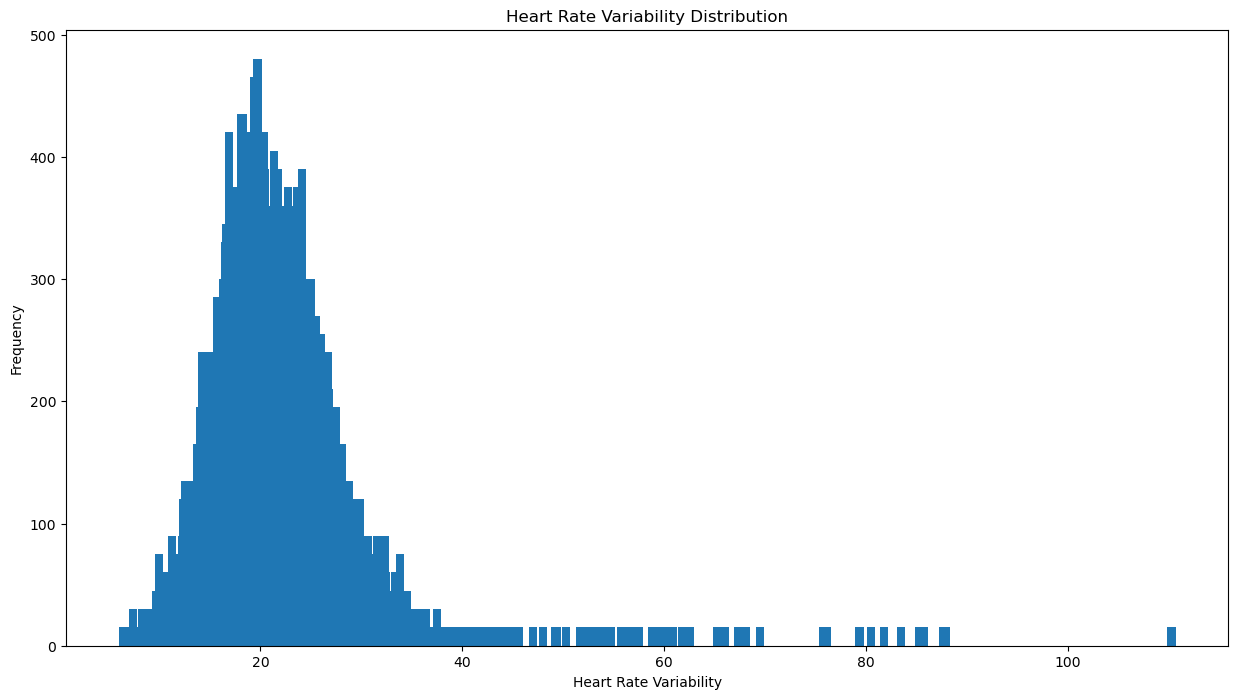

In [10]:
# Plot statistical data for the dataset
hrvs = data_pd["HRV"].value_counts()
nrows = 1
ncols = 1

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 8))

axs.bar(hrvs.index, hrvs.values)
axs.set_title("Heart Rate Variability Distribution")
axs.set_xlabel("Heart Rate Variability")
axs.set_ylabel("Frequency")


In [11]:
# Test data pipeline
test_non_linear_df  = pd.read_csv(test_non_linear_path)
test_time_domain_df = pd.read_csv(test_time_domain_path)
print("The initial non linear  test data contains {} rows and {} columns.".format(test_non_linear_df.shape[0], test_non_linear_df.shape[1]))
print("The initial time domain test data contains {} rows and {} columns.".format(test_time_domain_df.shape[0], test_time_domain_df.shape[1]))

# Drop unnecessary columns and join the data in one new dataframe
test_non_linear_df = test_non_linear_df.drop(columns=["SD1", "SD2", "sampen", "higuci", "datasetId"], axis=1)

columns_to_drop = ["MEAN_RR","MEDIAN_RR","SDRR","SDSD","SDRR_RMSSD","pNN25","pNN50","KURT","SKEW","MEAN_REL_RR","MEDIAN_REL_RR","SDRR_REL_RR",
                  "RMSSD_REL_RR","SDSD_REL_RR","SDRR_RMSSD_REL_RR","KURT_REL_RR","SKEW_REL_RR"]
test_time_domain_df = test_time_domain_df.drop(columns=columns_to_drop, axis=1)


# Merge the two dataframes
test_data = pd.merge(test_non_linear_df, test_time_domain_df, on=["uuid"], how="inner")
test_data.to_csv(os.path.join(data_path, "Heart_Rate_Prediction/Test_Data/test.csv"), index=False)
print("The merged test data contains {} rows and {} columns.".format(test_data.shape[0], test_data.shape[1]))

The initial non linear  test data contains 41033 rows and 7 columns.
The initial time domain test data contains 41033 rows and 19 columns.
The merged test data contains 41033 rows and 3 columns.


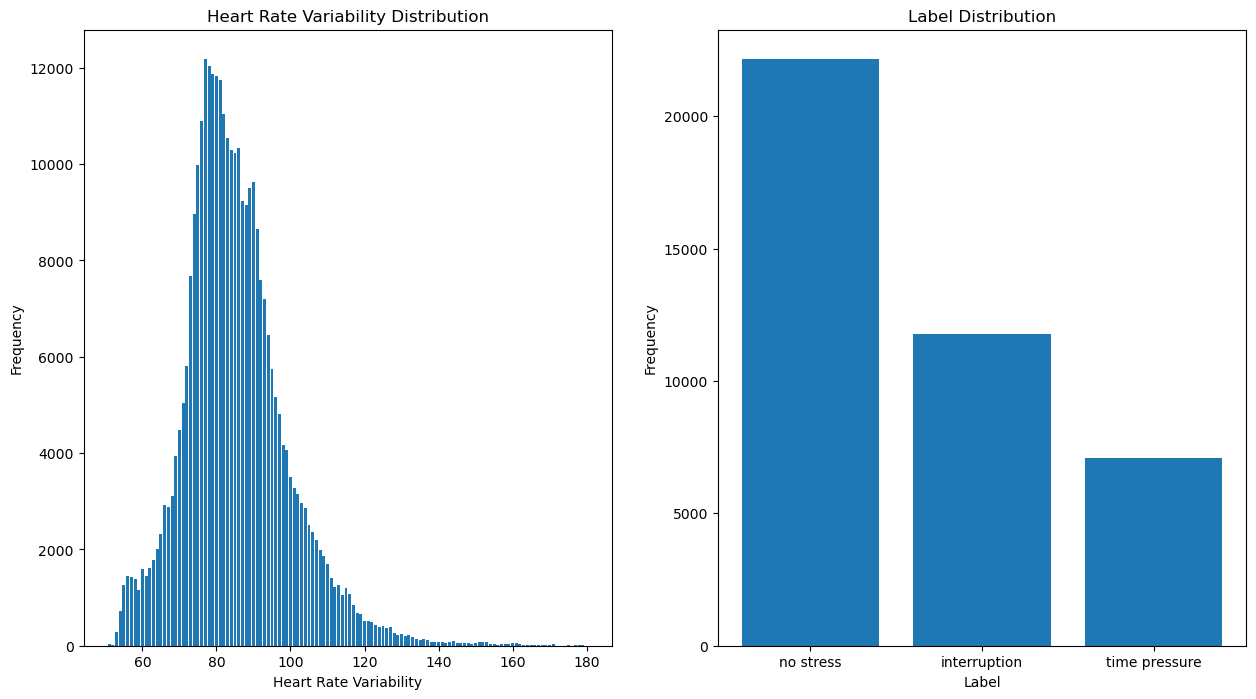

In [12]:
# Plot statistical data for the dataset
hrvs = test_data["RMSSD"].value_counts()
labels = test_data["condition"].value_counts()

nrows = 1
ncols = 2

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 8))

axs[0].bar(heart_rates.index, heart_rates.values)
axs[0].set_title("Heart Rate Variability Distribution")
axs[0].set_xlabel("Heart Rate Variability")
axs[0].set_ylabel("Frequency")

axs[1].bar(labels.index, labels.values)
axs[1].set_title("Label Distribution")
axs[1].set_xlabel("Label")
axs[1].set_ylabel("Frequency")
axs[1].set_xticks(labels.index)